In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Camera Calibration
***
We must first start with images that have all camera related distortion accounted for before further processing.

In [3]:
def calibrate_camera(calibration_dir, checker_grid_size=(9,6)):
    # read collection of checkerboard images and extract corners
    objpoints = []
    imgpoints = []
    
    (grid_x, grid_y) = checker_grid_size
    objp = np.zeros((grid_x * grid_y, 3), np.float32)
    objp[:,:2] = np.mgrid[0:grid_x, 0:grid_y].T.reshape(-1, 2)
    
    for cal_file in os.listdir(calibration_dir):
        path = os.path.join(calibration_dir, cal_file)
        img = plt.imread(path)
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, checker_grid_size, None)
        
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
        else:
            # Some images don't find the full 9x6 set of corners because they are cut off.
            # print here for warning though it isn't catastrophic.
            print("Failed to find checkerboard corners!:", cal_file)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return (mtx, dist) if ret else None

def undistort_image(img, cam_matrix, dist_params):
    return cv2.undistort(img, cam_matrix, dist_params, None, cam_matrix)

(cam_matrix, dist_params) = calibrate_camera('camera_cal')


Failed to find checkerboard corners!: calibration1.jpg
Failed to find checkerboard corners!: calibration4.jpg
Failed to find checkerboard corners!: calibration5.jpg


### Example: (note the lines have straightened out)
***

In [4]:
def before_after_plot(img_before, img_after, title_before, title_after, cmap_before=None, cmap_after=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_before, cmap=cmap_before)
    ax1.set_title(title_before, fontsize=50)
    ax2.imshow(img_after, cmap=cmap_after)
    ax2.set_title(title_after, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    

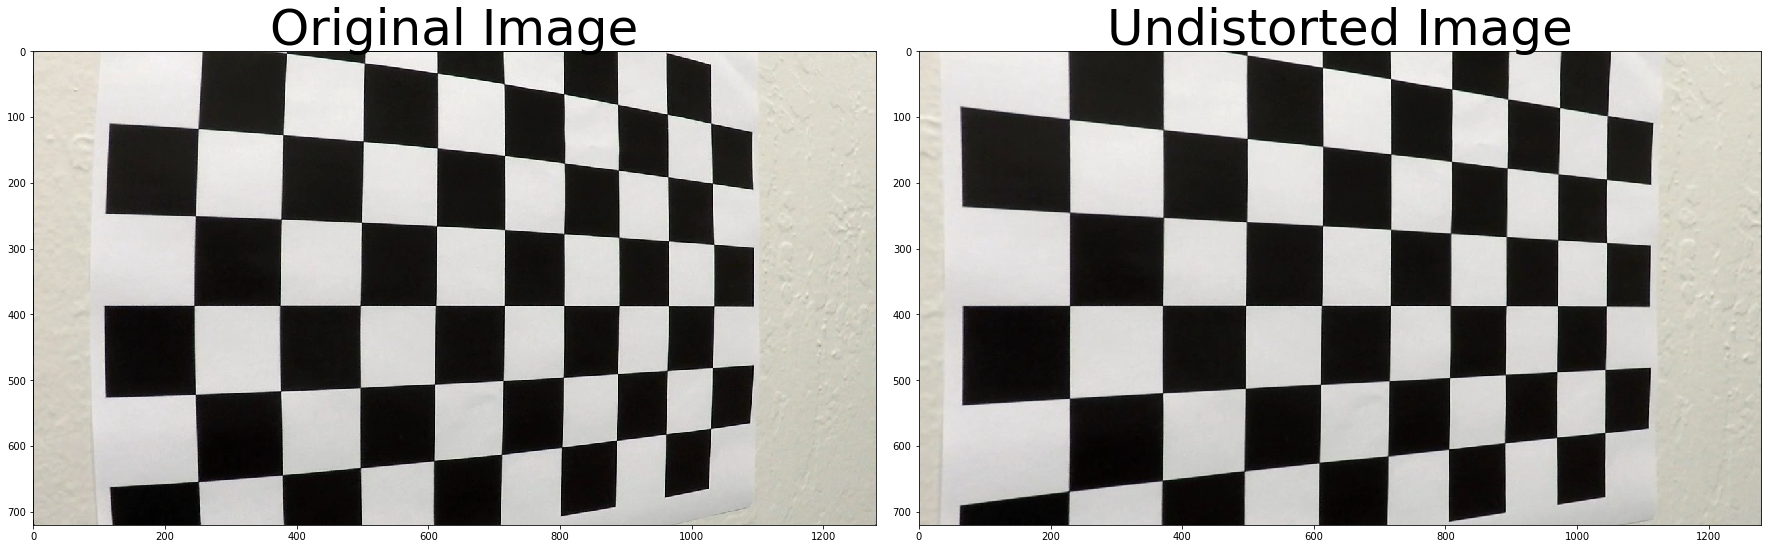

In [5]:
def ex1():
    img = plt.imread('camera_cal/calibration5.jpg')
    before_after_plot(img, undistort_image(img, cam_matrix, dist_params), 'Original Image', 'Undistorted Image')
ex1()

# Perspective Transformation
***
It is easier to process the curvature of lane lines when viewed from the top down.  Let's use a perspective transform to accomplish this.  To do this, we need to establish a correspondence between four points in the camera image to where we want the four corresponding locations to be in the top down image.

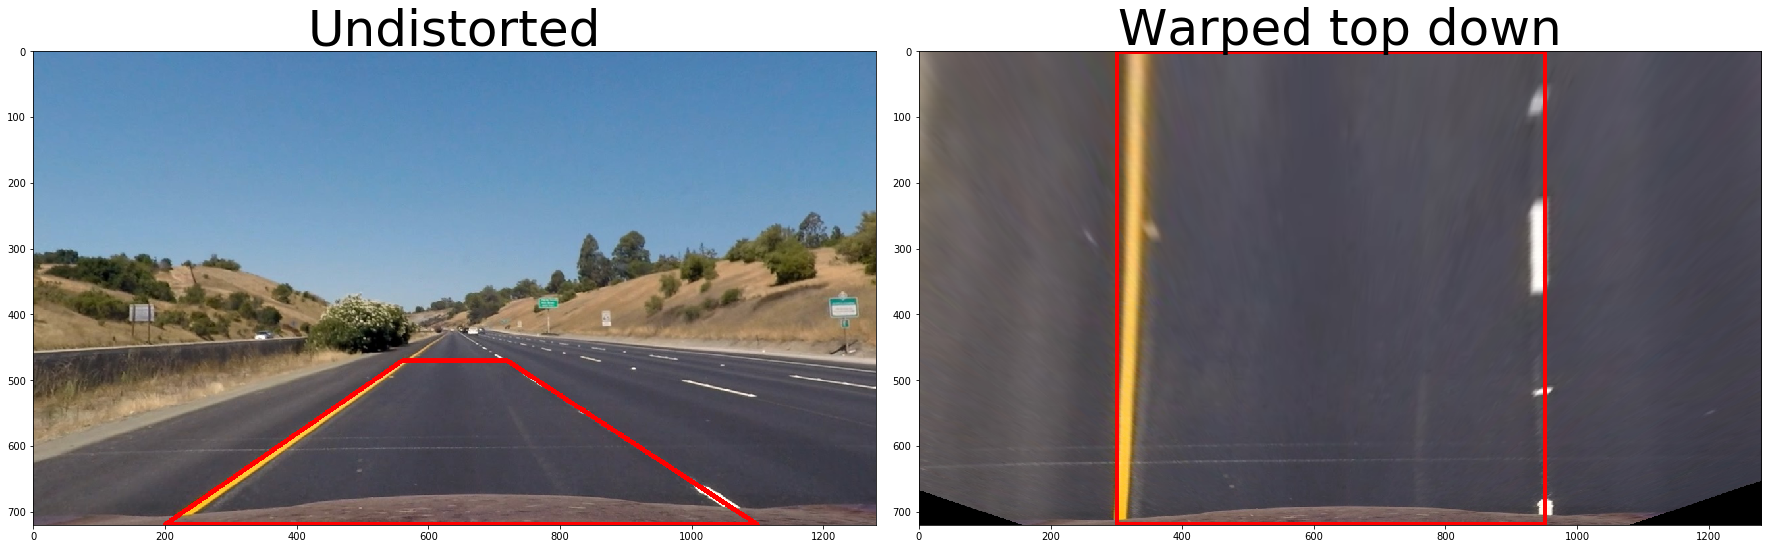

In [6]:
def ex2():
    img = plt.imread('test_images/straight_lines1.jpg')
    img = undistort_image(img, cam_matrix, dist_params)
    (height, width) = img.shape[:2]
    # bottom left, clockwise
    src_points = np.float32([(200, height-1), (560, 470), (720, 470), (1100, height-1)])
    dst_points = np.float32([(300, height-1), (300, 0),   (950, 0),   (950, height-1)])
    
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    # This will be useful later when we want to remap back to original image.
    Minv = cv2.getPerspectiveTransform(src_points, dst_points)
    
    top_down = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
    cv2.polylines(img, [src_points.reshape((-1,1,2)).astype(np.int32)], True, color=(255,0,0), thickness=5)
    cv2.polylines(top_down, [dst_points.reshape((-1,1,2)).astype(np.int32)], True, color=(255,0,0), thickness=5)

    before_after_plot(img, top_down, 'Undistorted', 'Warped top down')
    
    return (M, Minv)
    
(perspM, perspMinv) = ex2()

# Thresholding
***
Here, we do thresholding techniques to get a rough extraction of the lane lines.

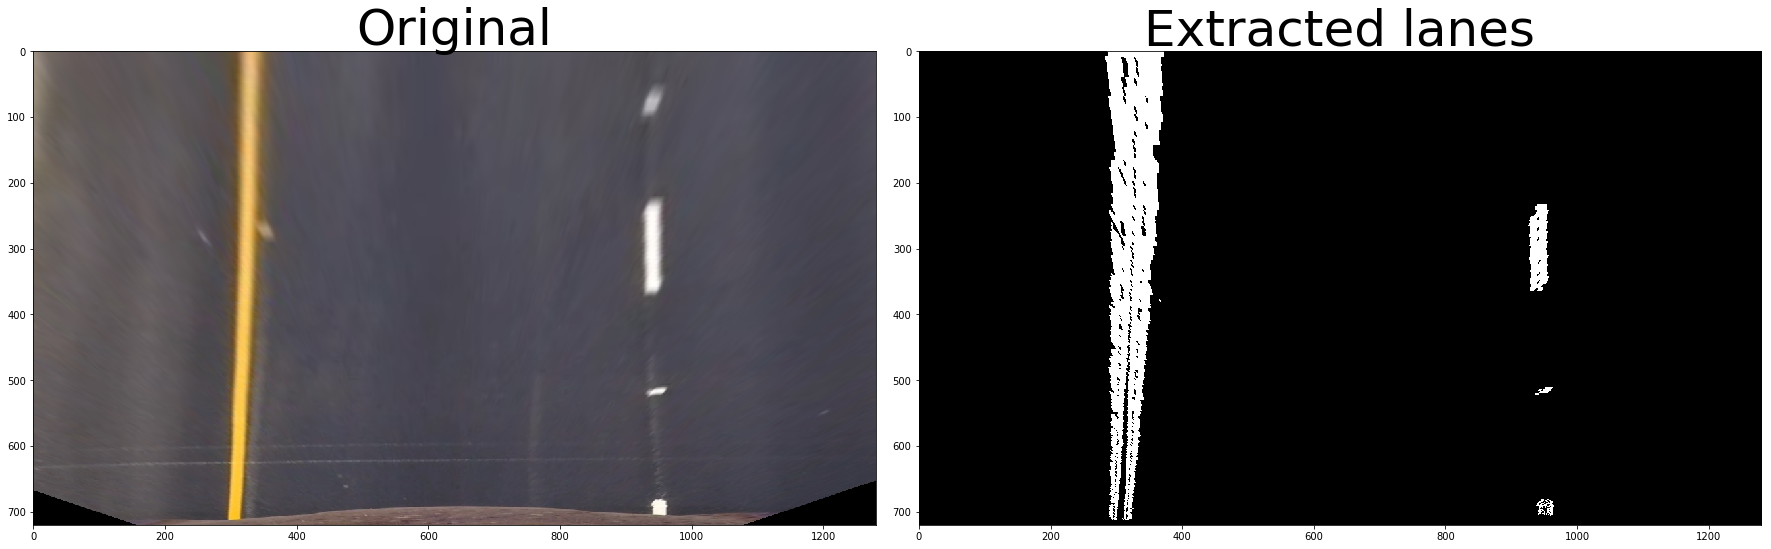

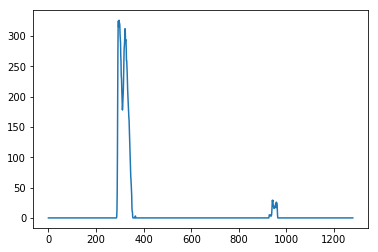

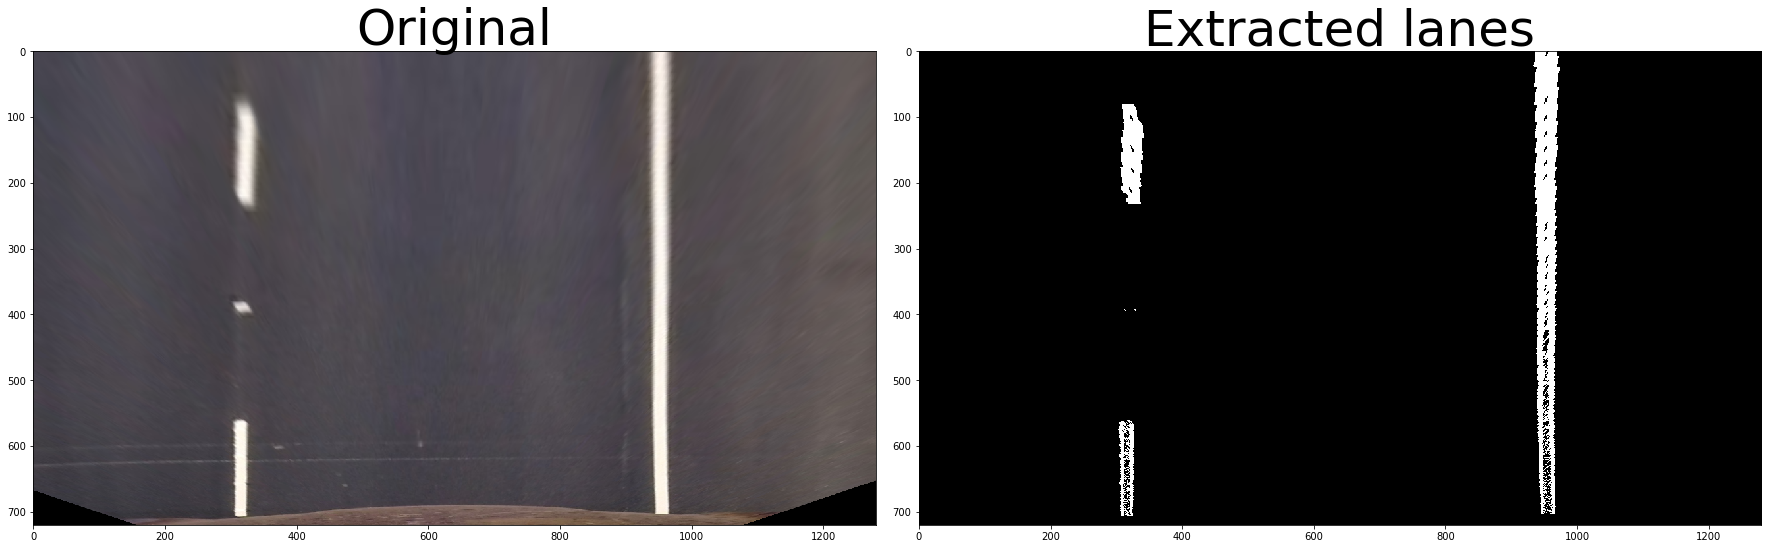

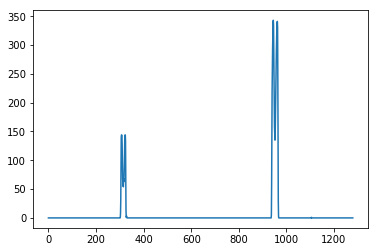

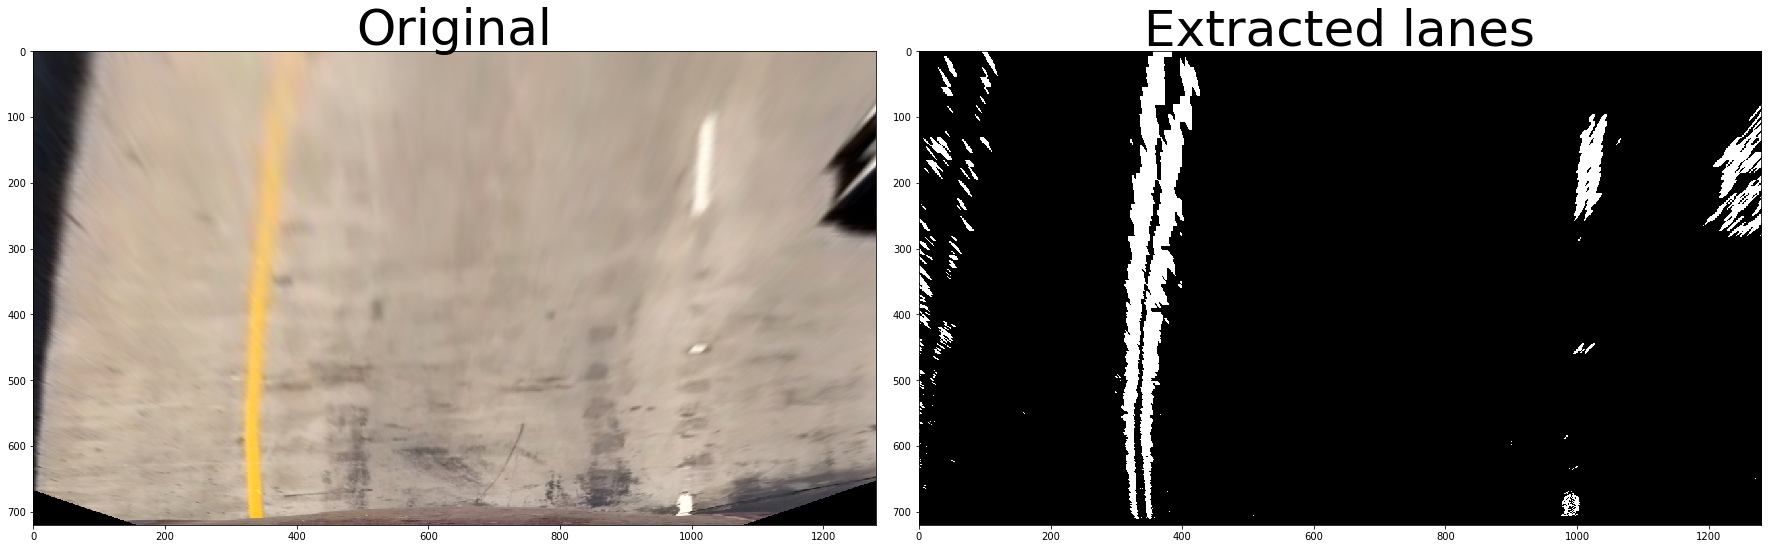

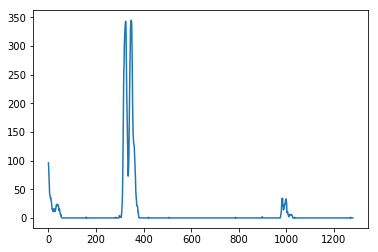

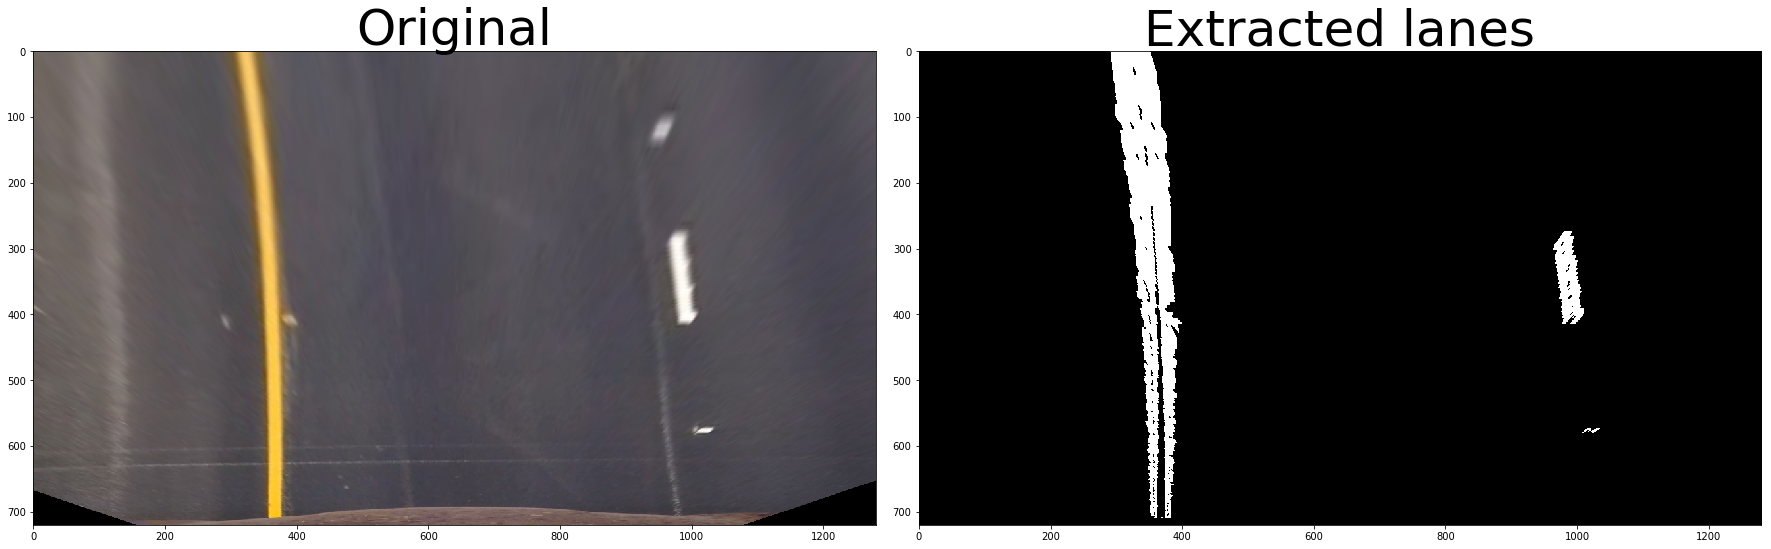

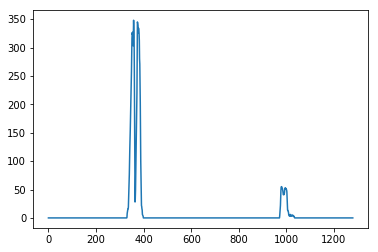

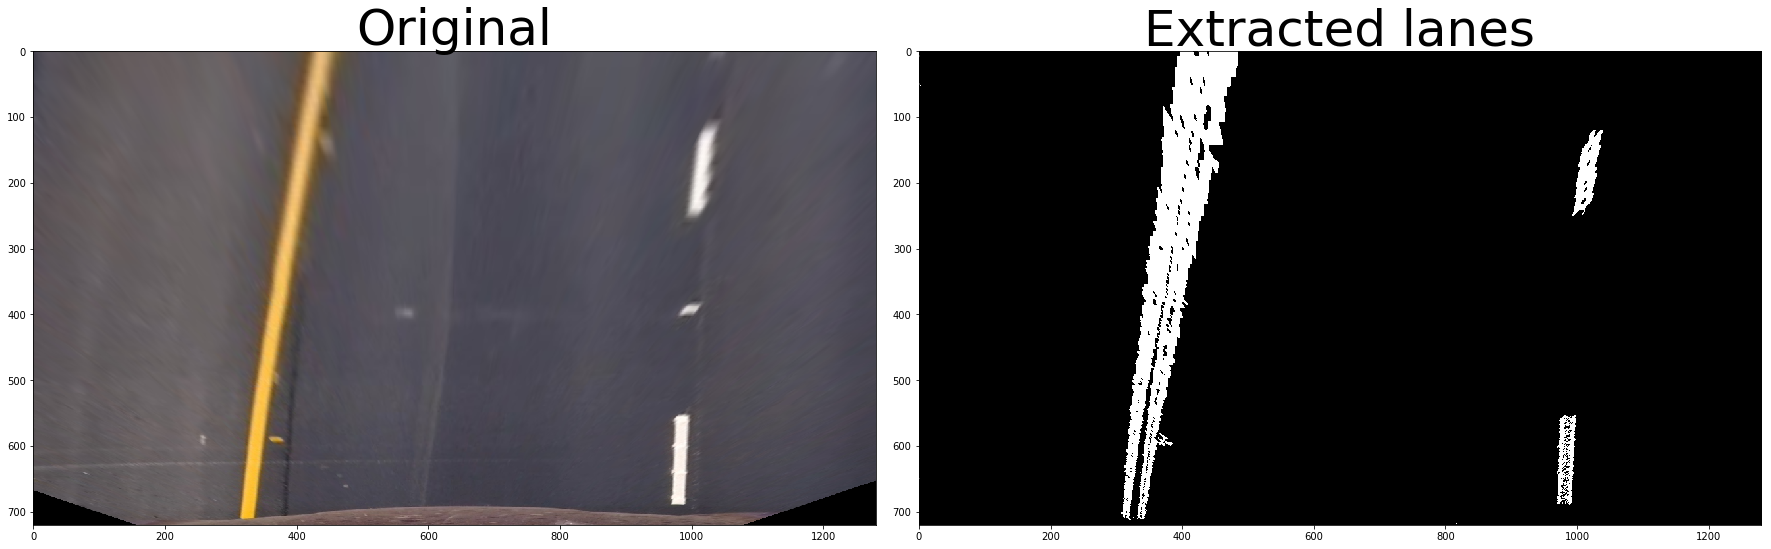

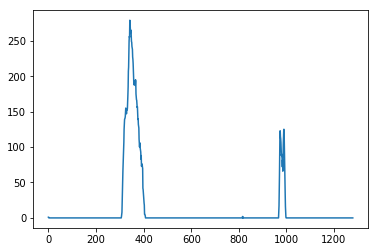

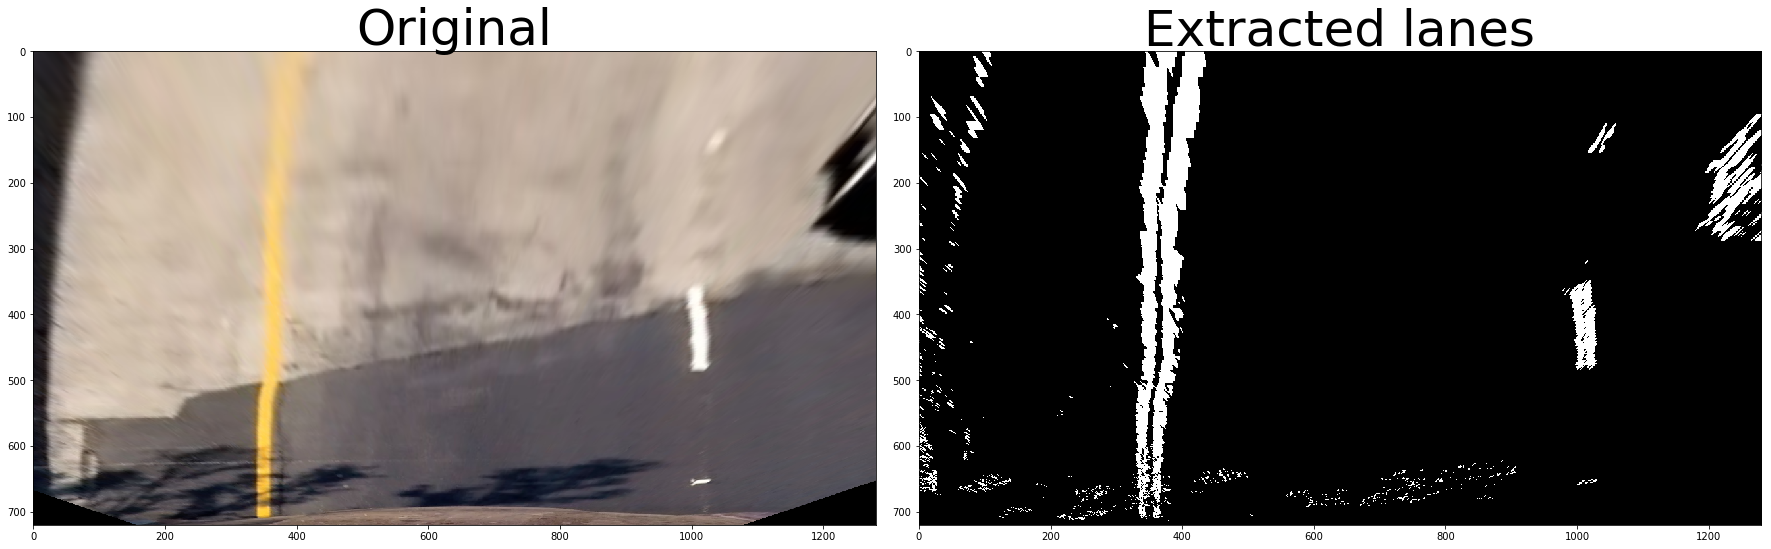

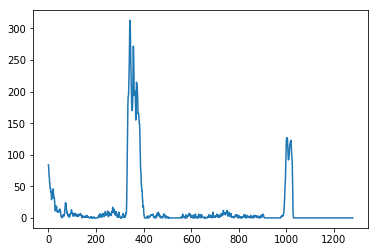

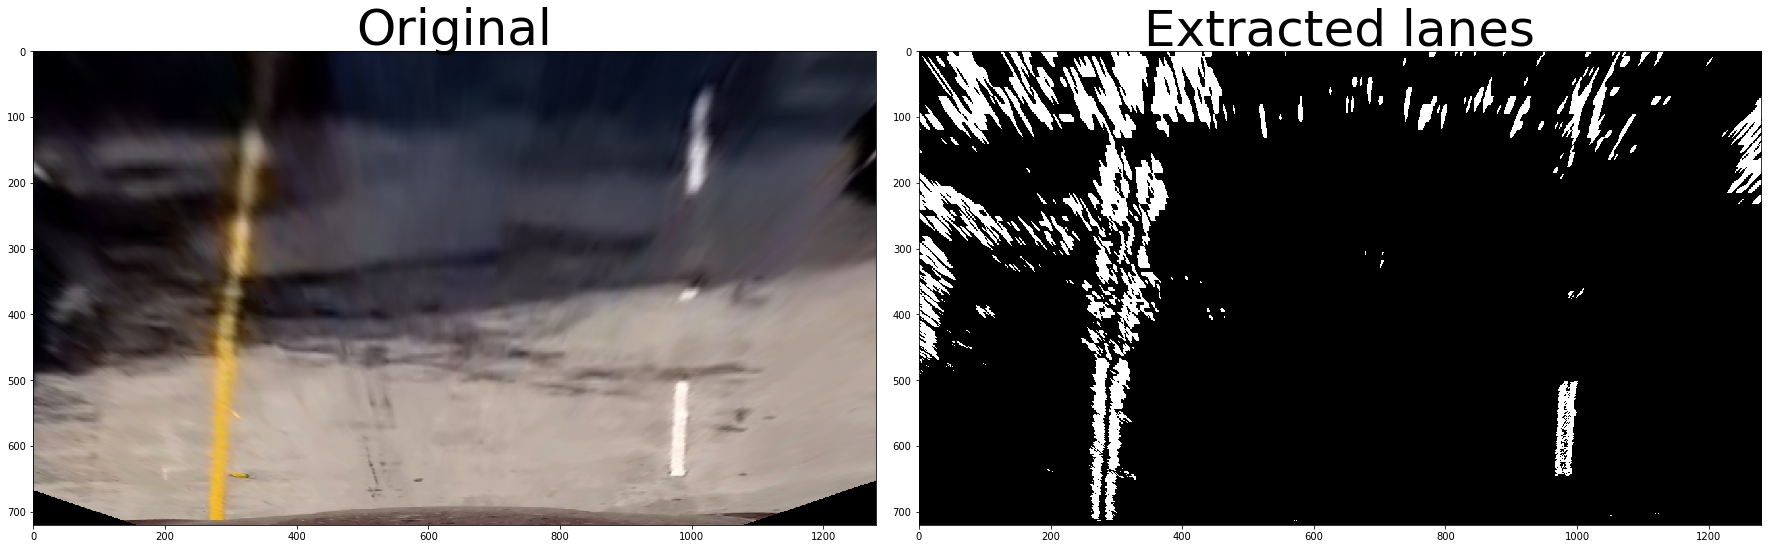

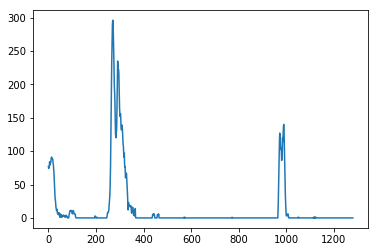

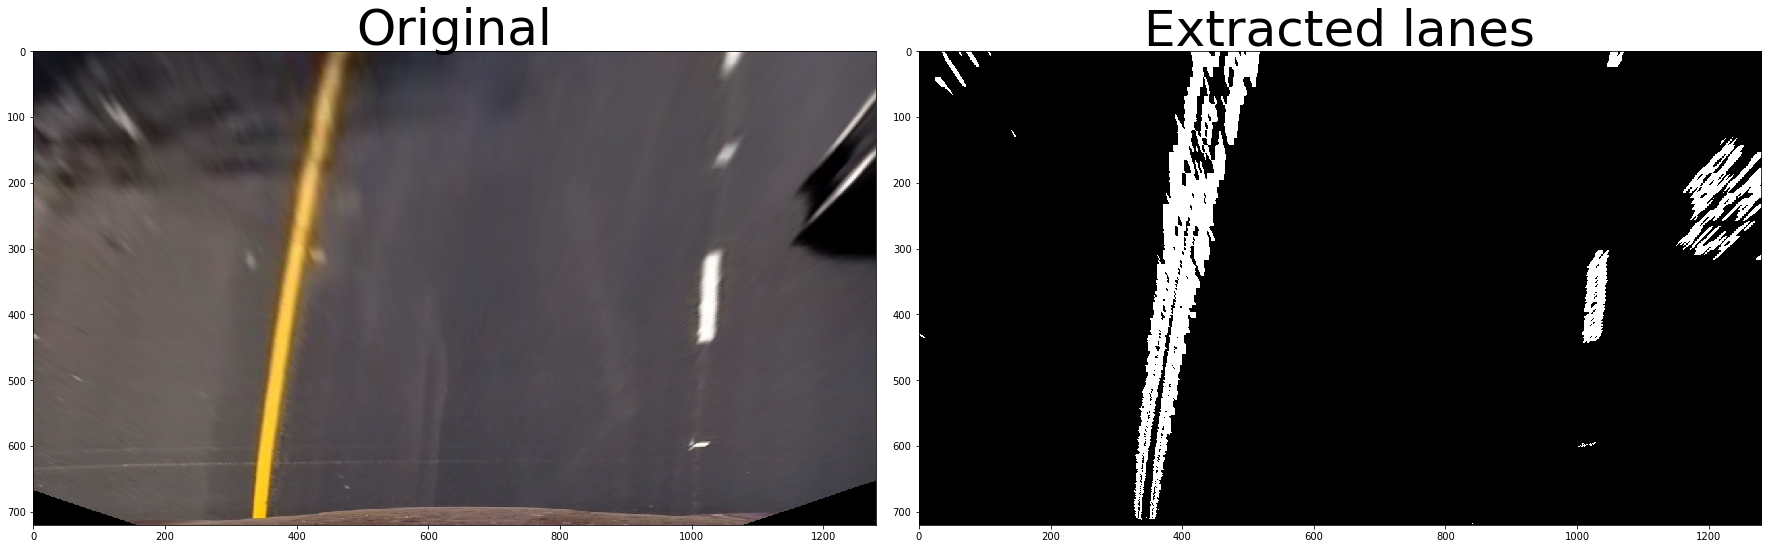

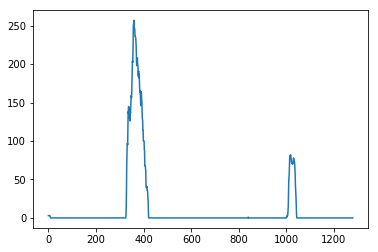

In [12]:
def lane_line_extract(img, threshx=50, threshy=50, mag_thresh=(20, 255), dir_thresh=(0.7, 1.3), ksize=3):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s   = hls[:,:,2]
    
    sobelx = np.abs(cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize=ksize))
    sobely = np.abs(cv2.Sobel(s, cv2.CV_64F, 0, 1, ksize=ksize))
    
    mag_sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
    dir_sobel = np.arctan2(sobely, sobelx)
    
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    binary = np.zeros_like(scaled_sobel)
    (mag_thresh_min, mag_thresh_max) = mag_thresh
    (dir_thresh_min, dir_thresh_max) = dir_thresh
    binary[(((scaled_sobel > mag_thresh_min) & (scaled_sobel <= mag_thresh_max)) &
            ((dir_sobel > dir_thresh_min) & (dir_sobel <= dir_thresh_max))) |
           ((sobelx > threshx) & (sobely > threshy))] = 1
    
    return binary

extracted_lanes_images = []

for file in os.listdir('test_images'):
    img = plt.imread(os.path.join('test_images', file))
    img = undistort_image(img, cam_matrix, dist_params)
    ext = lane_line_extract(img)
    ext = cv2.warpPerspective(ext, perspM, img.shape[:2][::-1], flags=cv2.INTER_LINEAR)
    img = cv2.warpPerspective(img, perspM, img.shape[:2][::-1], flags=cv2.INTER_LINEAR)
    before_after_plot(img, ext, 'Original', 'Extracted lanes', None, 'gray')
    histogram = np.sum(ext[ext.shape[0]//2:,:], axis=0)
    plt.figure()
    plt.plot(histogram)
    extracted_lanes_images.append(ext)

# Lane Finding
***
Use a sliding window to find peaks in # of pixels that indicate likely line positions.  Follow those up the image.

In [14]:
def get_lane_line_pixels(img, nwindows=9, margin=100, minpix=50):
    """
    nwindows - # of sliding windows
    margin   - Set the width of the windows +/- margin
    minpix   - Set minimum number of pixels found to recenter window
    """
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero  = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds  = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return (leftx, lefty, rightx, righty, out_img)

C:\Users\spillow\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


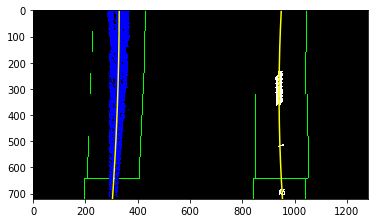

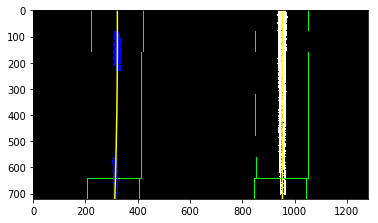

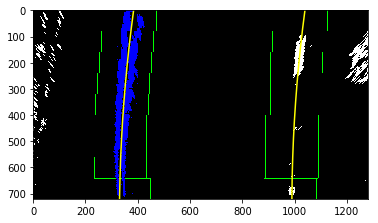

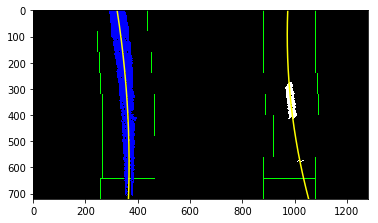

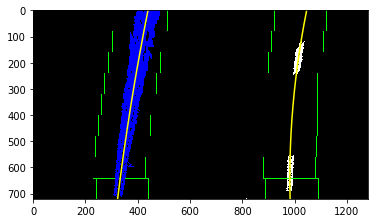

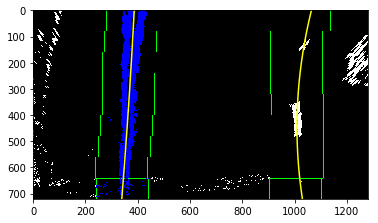

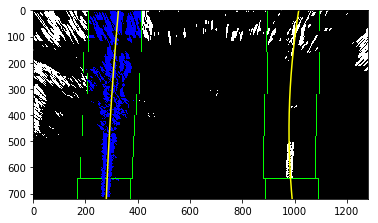

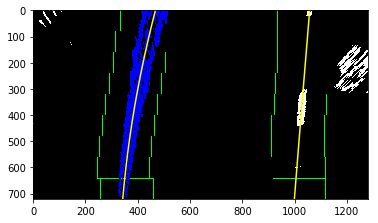

In [15]:
for ext_img in extracted_lanes_images:
    (leftx, lefty, rightx, righty, out_img) = get_lane_line_pixels(ext_img)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, ext_img.shape[0]-1, ext_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[lefty, leftx] = [0, 0, 255]
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)